In [1]:

import torch
# from tbparse import SummaryReader
from functools import partial
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import yaml
from tqdm import tqdm
# import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from tbparse import SummaryReader
from functools import reduce
from adjustText import adjust_text
# from tqdm.auto import tqdm  # for notebooks
from tqdm.notebook import tqdm
tqdm.pandas()
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 12})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})


# Overview: Load tensorboard files and plot them

Notebook to load in events files and plot them / save etc

## function development

In [2]:
# mapping of custom models to model names

def get_model_name(model_name_or_path:str) -> str:
    if "saved_models" in model_name_or_path:
        if "declutr" in model_name_or_path:
            if "few_epoch" in model_name_or_path:
                if "span_comparison" in model_name_or_path:
                    model_name = model_name_or_path.split("/")[9] + "/declutr/" + model_name_or_path.split("/")[-3]
                else:
                    model_name = model_name_or_path.split("/")[8] + "/declutr/" + model_name_or_path.split("/")[-3]

            else:
                model_name = model_name_or_path.split("/")[7] + "/declutr/" + model_name_or_path.split("/")[-3]
        elif "contrastive" in model_name_or_path or "custom_pretraining" in model_name_or_path:
            model_name = model_name_or_path.split("/")[7]
        elif "simcse" in model_name_or_path:# change this to be dynamic
            model_name = "simcse-mimic"
        else:
            model_name = model_name_or_path.split("/")[7]
    else:    
        model_name = model_name_or_path.split("/")[-1]
    
    return model_name

# an explicit mapping for paper model names

long_model_name_mappings = {
    "roberta-base": "RoBERTa-base",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
    "mimic-roberta-base": "RoBERTa-mimic",
    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
    "mimic-roberta-base/declutr/2_anch_2_pos_min_1024": "Mimic-RoBERTa-DeCLUTR",
    "Bio_ClinicalBERT": "Bio-ClinicalBERT",
    "sts_trf_roberta": "ST-TRF-RoBERTa",
    "all-mpnet-base-v2 ": "all-mpnet-base-v2",
    "biobert-v1.1": "BioBERT",
    "Llama-2-7b-hf": "Llama-2-7b",
    }

# task name mappings

task_name_mappings = {"icd9-triage-no-category-in-text": "ICD9-Triage",
                      "icd9-triage": "ICD9-Triage",
                      "ICD9-Triage": "ICD9-Triage"}

def get_configs(logs_dir, modeldir):
    # try open but skip if doesn't exist
    try:
        with open(logs_dir + modeldir + '/config.yaml') as f:        
            configs= yaml.load(f, Loader=yaml.FullLoader)
    except IOError as e:
        print(e)
        configs = {}
    configs['dir_name'] = modeldir
    return configs

# function to read in event files given a logdir and return a dataframe with config merged

def read_tb_files(logdir):
    
    # first use summary reader
    reader = SummaryReader(f"{logdir}/", extra_columns={'dir_name', 'wall_time'})
    df = reader.scalars
    # now load in config files

    config_list = df["dir_name"].drop_duplicates().progress_apply(
        lambda x: partial(get_configs, logdir)(x))
    config_df = pd.DataFrame.from_records(config_list)
    merged_df = pd.merge(df, config_df, on='dir_name')

    # we want to replace few_shot_n nan values with few_shot_n = "full"
    # check if few_shot_n is a column
    if "few_shot_n" in merged_df.columns:
        merged_df['few_shot_n'] = merged_df['few_shot_n'].fillna(250)
    
    # replace task name with mapping using replace function 
    merged_df['task'] = merged_df['task'].replace(task_name_mappings)

    # for now drop any that did not get a model name back i.e. config wasn't available
    merged_df = merged_df[merged_df['model_name_or_path'].notna()]

    # use model_name_or_path to get model name
    merged_df['Model name'] = merged_df['model_name_or_path'].progress_apply(lambda x: get_model_name(x))

    # now map to a more suitable name
    merged_df["Model name"] = merged_df["Model name"].replace(long_model_name_mappings)
    
    
    return merged_df

def extract_metric(logs_df,
                   mode = "all",
                    metrics = "all",                     
                    sample_sizes = None, 
                    save_csv = False):
    '''
    Function to pull certain specified features from the full logs dataframes
    
    Args: 
        mode: The dataset you want metrics for e.g. train/valid/test            
        metrics: The metric you want to look at e.g. f1, precision etc.

        tasks: list of specific tasks to extract - None by default means all tasks
        analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment

    Returns: 
        dataframe containing organised and subsetted metrics based on arguments provided
    '''


    if metrics == "all" and mode == "all":
        return logs_df
    
    # now for cases where mode is specific        
    elif metrics == "all" and mode != "all": 
        metrics_df = logs_df[logs_df["tag"].str.contains(mode)]            
    
    
    # cases where metric is specific but mode is all
    elif metrics != "all" and mode == "all":
        metrics_df =  logs_df.loc[logs_df['tag'].str.contains('|'.join(metrics))]
    
    # now for cases where both metric and mode are specific
    elif metrics != "all" and mode != "all":
        
        # handle multiple specific metrics
        metrics_df = logs_df[logs_df['tag'].str.contains('|'.join(metrics)) & (logs_df["tag"].str.contains(mode))]
        # metrics_df = logs_df[(logs_df["tag"].str.contains(metrics)) & (logs_df["tag"].str.contains(mode))]    

    
    
    return metrics_df

def produce_results_table(logs_df,
                            metric = "f1_macro", # do not use all here
                            mode = "eval",
                            groupby_list = ["Model name", "few_shot_n"],
                            task_type = "SEQ_CLS", # | TOKEN_CLS
                            value_aggregate_method = "mean",
                            log_collection = "all", # | span
                            plm = "Frozen" # | Finetuned
                                ):

        ''' 
        Function to produce a semi-formatted table based on a metric of interest grouped by key features
        '''
        # extract the metrics based on params
        
        
        
        
        
        tb_metrics = extract_metric( logs_df,  metrics = metric,
                                            mode = mode)
        
        # drop rows that are != task_type and if task_type is not specified then keep all
        if task_type is not None:
            
            tb_metrics = tb_metrics[tb_metrics['task_type'] == task_type]

        # remove eval from the tag column
        # tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"eval/",'')
        tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"test/",'')
        
         # # replace sample sizes of 250 to "full"
        # tb_metrics['Sample size'] = tb_metrics['Sample size'].replace(250,"full")        
        
        grouped_metrics = (tb_metrics.pivot_table(index=groupby_list, 
                    columns='tag', 
                    values='value',
                    aggfunc=value_aggregate_method)
                    .reset_index())
        
        
        

        return grouped_metrics.reset_index() # remove reset_index if it breaks anything

### Get number of trainable parameters for each model type



In [3]:
with open('../trainable_params.yaml', 'r') as f:
    trainable_params_mapping = yaml.load(f, yaml.FullLoader)

with open('../model_type_trainable_model_size.yaml', 'r') as f:
    model_type_size_mappings = yaml.load(f, yaml.FullLoader)

with open('../gpu_memory_needed.json', 'r') as f:
    gpu_memory_needed = yaml.load(f, yaml.FullLoader)

In [4]:
list(trainable_params_mapping.keys())

['/mnt/sdc/niallt/saved_models/declutr/mimic/few_epoch/mimic-roberta-base/2_anch_2_pos_min_1024/transformer_format/',
 '/mnt/sdc/niallt/saved_models/language_modelling/mimic/mimic-roberta-base/sampled_250000/22-12-2022--12-45/checkpoint-100000/',
 '/mnt/sdc/niallt/saved_models/language_modelling/mimic/roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted/sampled_250000/07-07-2023--08-30/checkpoint-30000/',
 'dmis-lab/biobert-v1.1',
 'emilyalsentzer/Bio_ClinicalBERT',
 'meta-llama/Llama-2-7b-hf',
 'michiyasunaga/BioLinkBERT-base',
 'michiyasunaga/LinkBERT-base',
 'nlpie/bio-mobilebert',
 'nlpie/distil-biobert',
 'nlpie/tiny-biobert',
 'roberta-base']

In [5]:
trainable_params_mapping["roberta-base"]

{'Full': {'full_model_size_GB': 0.9287792639806867,
  'full_model_size_MB': 951.0699663162231,
  'model_size_GB': 0.46434689313173294,
  'model_size_MB': 475.49121856689453,
  'n_peft_params': 124055040,
  'n_peft_params_perc': 99.524955119318,
  'peft_full_model_size_GB': 0.9287792639806867,
  'peft_full_model_size_MB': 951.0699663162231,
  'peft_model_size_GB': 0.46434689313173294,
  'peft_model_size_MB': 475.49121856689453,
  'total_params': 124647170},
 'IA3': {'full_model_size_GB': 0.9287792639806867,
  'full_model_size_MB': 951.0699663162231,
  'model_size_GB': 0.46434689313173294,
  'model_size_MB': 475.49121856689453,
  'n_peft_params': 64512,
  'n_peft_params_perc': 0.05175568767425686,
  'peft_full_model_size_GB': 0.9287792639806867,
  'peft_full_model_size_MB': 951.0699663162231,
  'peft_model_size_GB': 0.46434689313173294,
  'peft_model_size_MB': 475.49121856689453,
  'total_params': 124647170},
 'LORA': {'full_model_size_GB': 0.9287792639806867,
  'full_model_size_MB': 951

In [6]:
gpu_memory_needed

{'nlpie/bio-mobilebert': 0.09157848358154297,
 'nlpie/tiny-biobert': 0.05176830291748047,
 'roberta-base': 0.46604251861572266,
 'nlpie/distil-biobert': 0.24604511260986328,
 'dmis-lab/biobert-v1.1': 0.40447139739990234,
 'meta-llama/Llama-2-7b-hf': 24.739288330078125}

## Load in events files



In [7]:
logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'
logs_df = read_tb_files(logs_dir)

KeyboardInterrupt: 

### investigate files

In [7]:
logs_df.head(2)

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name
0,299,eval/accuracy,0.925498,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
1,598,eval/accuracy,0.940912,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
2,897,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
3,1196,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
4,1495,eval/accuracy,0.949261,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert


In [8]:
logs_df.columns

Index(['step', 'tag', 'value', 'dir_name', 'cache_dir', 'ckpt_save_dir',
       'combined_val_test_sets', 'custom_model_name', 'data_dir', 'dropout',
       'early_stopping_patience', 'early_stopping_threshold',
       'eight_bit_training', 'eval_batch_size', 'eval_data_dir',
       'eval_every_steps', 'eval_few_shot_n', 'evaluation_strategy',
       'fast_dev_run', 'few_shot_n', 'label_col', 'label_name',
       'learning_rate', 'loader_workers', 'log_every_steps', 'log_save_dir',
       'lora_alpha', 'lora_dropout', 'lora_rank', 'max_epochs', 'max_length',
       'metric_mode', 'model_name_or_path', 'monitor', 'n_trainable_params',
       'no_cuda', 'num_virtual_tokens', 'optimizer', 'optuna', 'patience',
       'peft_method', 'pretrained_models_dir', 'remove_columns',
       'save_adapter', 'save_every_steps', 'saving_strategy', 'task',
       'task_to_keys', 'task_type', 'test_file', 'text_col', 'text_column',
       'time_budget', 'train_batch_size', 'training_data_dir', 'training

In [9]:
logs_df.model_name_or_path.unique()

array(['nlpie/bio-mobilebert', 'dmis-lab/biobert-v1.1',
       'nlpie/distil-biobert', 'nlpie/tiny-biobert'], dtype=object)

In [10]:
logs_df["Model name"].unique()

array(['bio-mobilebert', 'BioBERT', 'distil-biobert', 'tiny-biobert'],
      dtype=object)

In [11]:
# check unique tasks 
logs_df.task.value_counts()

task
i2b2-2014-NER    33255
mimic-mp         25110
mimic-los        22590
i2b2-2010-RE     16875
ICD9-Triage       7920
i2b2-2012-NER     5715
i2b2-2010-NER     5670
Name: count, dtype: int64

In [12]:
# check unique tags
logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/loss', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'test/accuracy', 'test/f1_macro',
       'test/f1_micro', 'test/f1_weighted', 'test/loss', 'test/precision',
       'test/recall', 'test/roc_auc_macro', 'test/runtime',
       'test/samples_per_second', 'test/steps_per_second', 'train/epoch',
       'train/learning_rate', 'train/loss', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'eval/f1', 'test/f1'], dtype=object)

In [13]:
# check unique few shot values
logs_df.few_shot_n.unique()

array([250])

In [15]:
metrics = ['f1','precision','recall','accuracy']
logs_df[logs_df['tag'].str.contains('|'.join(metrics))]

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name
0,299,eval/accuracy,0.925498,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
1,598,eval/accuracy,0.940912,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
2,897,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
3,1196,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
4,1495,eval/accuracy,0.949261,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115517,5310,test/f1_macro,0.472474,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115518,5310,test/f1_micro,0.895642,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115519,5310,test/f1_weighted,0.846336,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115521,5310,test/precision,0.447821,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert


In [16]:
# i think few_shot_n values of nan are for the full training set
# check example of one with na 
logs_df[logs_df.few_shot_n.isna()].head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name


## Pull out metrics etc

Below will retrieve all metrics of choice for each task and return the max

In [4]:
cls_results_df = produce_results_table(logs_df, 
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

NameError: name 'logs_df' is not defined

In [21]:
cls_results_df.task.unique()

array(['ICD9-Triage', 'i2b2-2010-RE', 'mimic-los', 'mimic-mp'],
      dtype=object)

In [22]:
cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'peft_method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second'],
      dtype='object', name='tag')

### trainable_params_mapping

In [95]:
trainable_params_mapping['roberta-base']['LORA'].keys()

dict_keys(['full_model_size_GB', 'full_model_size_MB', 'model_size_GB', 'model_size_MB', 'n_peft_params', 'n_peft_params_perc', 'peft_full_model_size_GB', 'peft_full_model_size_MB', 'peft_model_size_GB', 'peft_model_size_MB', 'total_params'])

In [96]:
cls_results_df["PEFT_params"] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('n_peft_params', np.NaN), axis=1)
cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('total_params', np.NaN), axis=1)
cls_results_df['full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['peft_method'], {}).get('model_size_GB', np.NaN), axis=1)
cls_results_df['full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['peft_method'], {}).get('model_size_MB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['peft_method'], {}).get('peft_model_size_GB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['peft_method'], {}).get('peft_model_size_MB', np.NaN), axis=1)


In [25]:
cls_results_df.head(3)

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
0,0,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,Full,0.946406,0.947013,0.874629,0.947013,...,1160.397217,41.188000,1.288,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
1,1,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,IA3,0.914250,0.911047,0.683493,0.911047,...,954.451477,50.076000,1.566,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,LORA,0.938840,0.939949,0.847556,0.939949,...,966.834106,49.435001,1.546,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765


In [21]:
# below doesn't handle mappings with no values
# cls_results_df['PEFT_params'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['n_peft_params'], axis=1)
# cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['n_peft_params_perc'], axis=1)
# cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['total_params'], axis=1)

In [10]:
# cls_results_df.loc[
#     cls_results_df['few_shot_n'] > 200].sort_values(
#                                         ['task', 'f1_macro'], 
#                                         ascending=[True, False]).head(20)

In [120]:
# get remaining NER
ner_results_df = produce_results_table(logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc"],
                                        mode = "all",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                        task_type = "TOKEN_CLS",
                                        value_aggregate_method = "max",
                                        )

In [121]:
ner_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,Full,0.930603,0.947615,0.857877,0.856037,0.864545,0.821867,0.821637,0.822097
1,1,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,IA3,0.830793,0.847326,0.454201,0.464756,0.444115,0.471903,0.499843,0.446920
2,2,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,LORA,0.905475,0.923514,0.732703,0.748841,0.717246,0.713018,0.730265,0.696567
3,3,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,PREFIX_TUNING,0.818223,0.838363,0.445300,0.464257,0.427831,0.453597,0.493298,0.419810
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,Full,0.906669,0.914063,0.848851,0.842254,0.859592,0.823431,0.809410,0.837946
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,IA3,0.795349,0.795515,0.481382,0.485276,0.477551,0.488838,0.491421,0.486283
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,LORA,0.887448,0.896688,0.786780,0.780399,0.796735,0.756664,0.747420,0.766138
7,7,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,PREFIX_TUNING,0.774790,0.773346,0.443478,0.450000,0.437143,0.445669,0.450759,0.440694
8,8,BioBERT,dmis-lab/biobert-v1.1,i2b2-2014-NER,250,Full,0.996772,0.996574,0.964678,0.966003,0.968151,0.968502,0.971618,0.965406
9,9,BioBERT,dmis-lab/biobert-v1.1,i2b2-2014-NER,250,IA3,0.986155,0.986531,0.848464,0.852794,0.844178,0.849201,0.857696,0.840873


## Plots

In [54]:
# set plotting save path
save_path = "/mnt/sdd/efficient_ml_data/figures_and_plots/"

### Sequence Classification

#### Peft method plot - Sequence Classification

In [130]:
# peft_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full']
peft_methods_to_plot = ['PREFIX_TUNING', 'IA3', 'LORA', 'Full']
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] > 200].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert', "BioBERT"
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]

plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

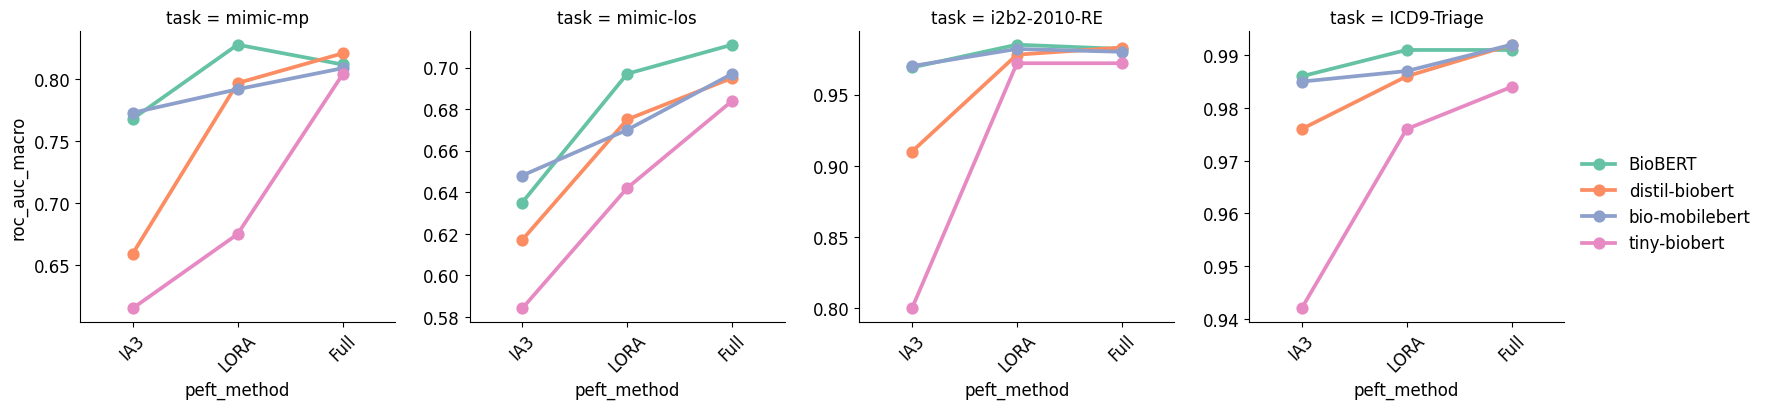

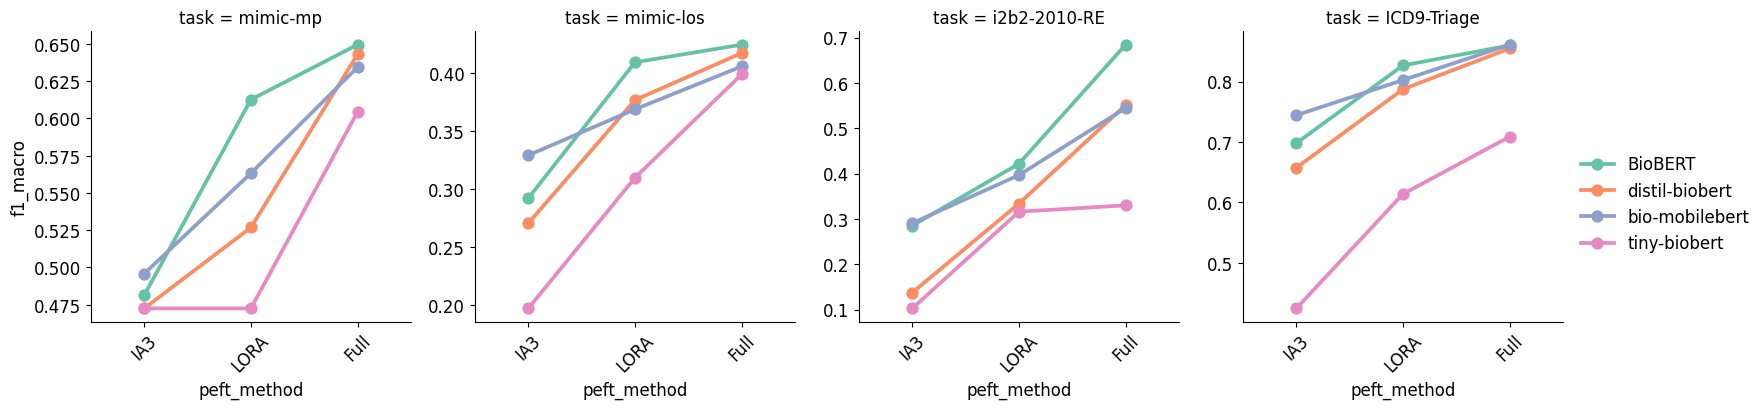

In [107]:


metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='peft_method', y=metric, hue='Model name', 
                    order=peft_methods_to_plot, 
                    hue_order = ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.savefig(f'{save_path}/{metric}_peft_methods.png', bbox_inches='tight')
    plt.show()


In [135]:
# make a latex table from this

cls_paper_results = plot_df.groupby(['Model name', 'peft_method', 'task', 'few_shot_n'])['roc_auc_macro'].max().reset_index().pivot_table(index=['Model name', 'peft_method'],
                                                                                                        columns=['task',],
                                                                                                        values='roc_auc_macro').reset_index()
print(cls_paper_results.to_latex(
            caption = "PEFT results for CLS tasks",
            label = "peft-cls-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))

\begin{table}[htp]
\centering
\caption{PEFT results for CLS tasks}
\label{peft-cls-results}
\begin{tabular}{llrrrr}
\toprule
    Model name &   peft\_method &  ICD9-Triage &  i2b2-2010-RE &  mimic-los &  mimic-mp \\
\midrule
       BioBERT &          Full &        0.991 &         0.982 &      0.711 &     0.812 \\
       BioBERT &           IA3 &        0.986 &         0.969 &      0.635 &     0.768 \\
       BioBERT &          LORA &        0.991 &         0.985 &      0.697 &     0.828 \\
       BioBERT & PREFIX\_TUNING &        0.951 &         0.892 &      0.577 &     0.616 \\
bio-mobilebert &          Full &        0.992 &         0.980 &      0.697 &     0.809 \\
bio-mobilebert &           IA3 &        0.985 &         0.970 &      0.648 &     0.773 \\
bio-mobilebert &          LORA &        0.987 &         0.982 &      0.670 &     0.792 \\
distil-biobert &          Full &        0.992 &         0.983 &      0.695 &     0.821 \\
distil-biobert &           IA3 &        0.976 &       

/tmp/ipykernel_39291/757057626.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cls_paper_results.to_latex(


#### Number of trainable parameters

In [14]:
plot_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
59,59,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250,PREFIX_TUNING,0.895642,0.894458,0.472145,0.894458,...,581.825195,291.789001,9.126,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
55,55,tiny-biobert,nlpie/tiny-biobert,mimic-los,250,PREFIX_TUNING,0.378311,0.366431,0.134083,0.366431,...,516.727905,294.362000,9.202,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
51,51,tiny-biobert,nlpie/tiny-biobert,i2b2-2010-RE,250,PREFIX_TUNING,0.854186,0.853116,0.102304,0.853116,...,226.291595,491.755005,15.378,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
47,47,tiny-biobert,nlpie/tiny-biobert,ICD9-Triage,250,PREFIX_TUNING,0.554224,0.544958,0.145761,0.544958,...,186.902496,255.722000,7.999,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
58,58,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250,LORA,0.895642,0.894458,0.472145,0.894458,...,603.383789,281.363007,8.800,39936,0.287832,13874762,0.051688,52.928017,0.051688,52.928017


In [15]:
cls_results_df["Model name"].unique()

array(['BioBERT', 'bio-mobilebert', 'distil-biobert', 'tiny-biobert'],
      dtype=object)

In [99]:
peft_methods_to_plot = ["IA3", "LORA","Full"]

In [100]:
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] > 200].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]
plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [101]:
plot_df["Model name"].unique()

array(['tiny-biobert', 'distil-biobert', 'bio-mobilebert', 'BioBERT'],
      dtype=object)

In [102]:
# check data with BioBERT Model name
plot_df.loc[plot_df["Model name"] == "BioBERT"]

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
14,14,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,250,LORA,0.898799,0.898329,0.605660,0.898329,...,3146.214111,53.959999,1.688,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
10,10,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,LORA,0.439127,0.420405,0.397078,0.420405,...,2799.647949,54.330002,1.698,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,LORA,0.926791,0.925488,0.421195,0.925488,...,1333.473877,83.450996,2.610,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,LORA,0.938840,0.939949,0.847556,0.939949,...,966.834106,49.435001,1.546,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
13,13,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,250,IA3,0.896355,0.895069,0.479796,0.895069,...,3103.387939,54.705002,1.711,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
9,9,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,IA3,0.396499,0.390572,0.288559,0.390572,...,2786.532471,54.585999,1.706,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,IA3,0.897581,0.895860,0.284792,0.895860,...,1313.807373,84.699997,2.649,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
1,1,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,IA3,0.914250,0.911047,0.683493,0.911047,...,954.451477,50.076000,1.566,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
12,12,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,250,Full,0.889126,0.900367,0.640841,0.900367,...,3798.227051,44.696999,1.398,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
8,8,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,Full,0.454473,0.434753,0.408146,0.434753,...,3420.683350,44.466000,1.390,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765


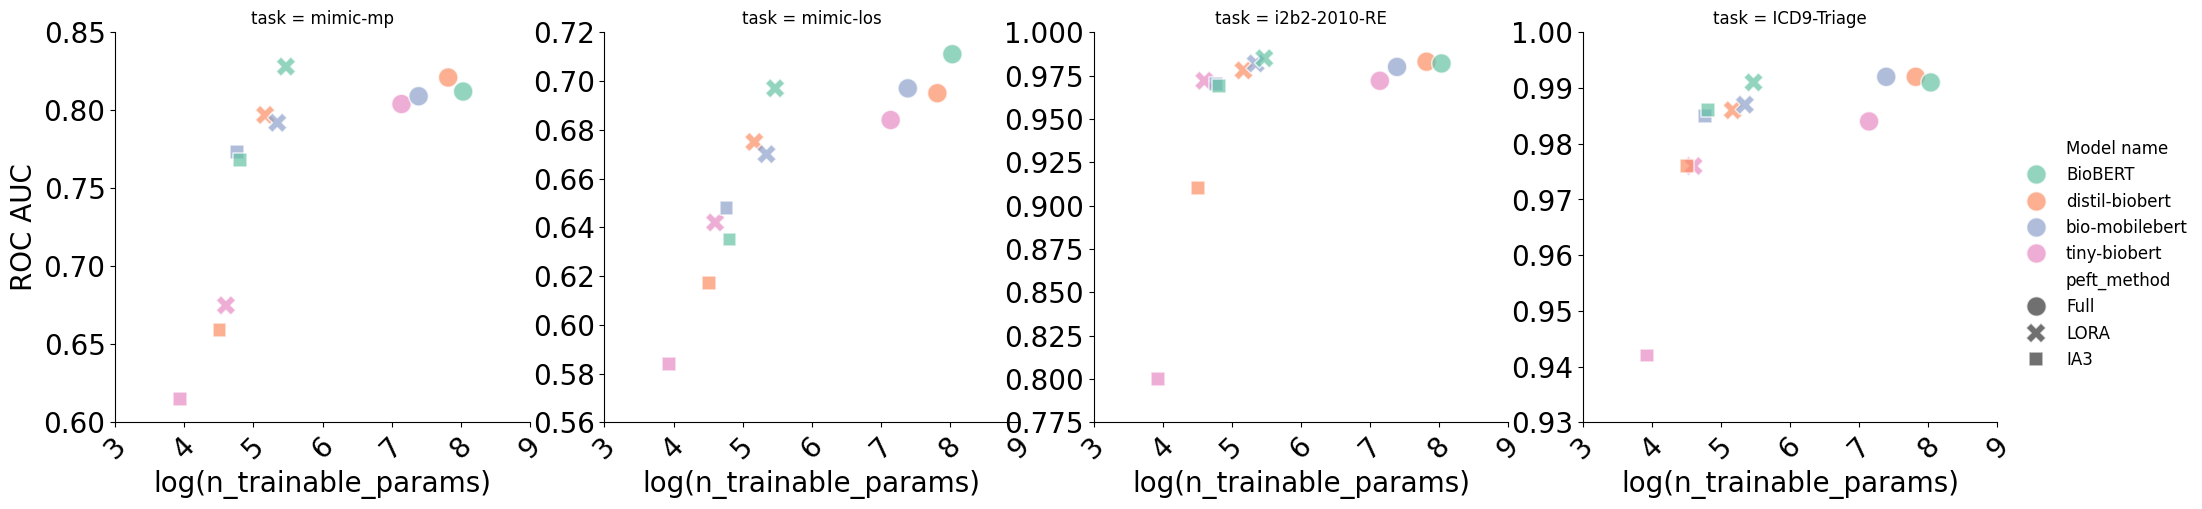

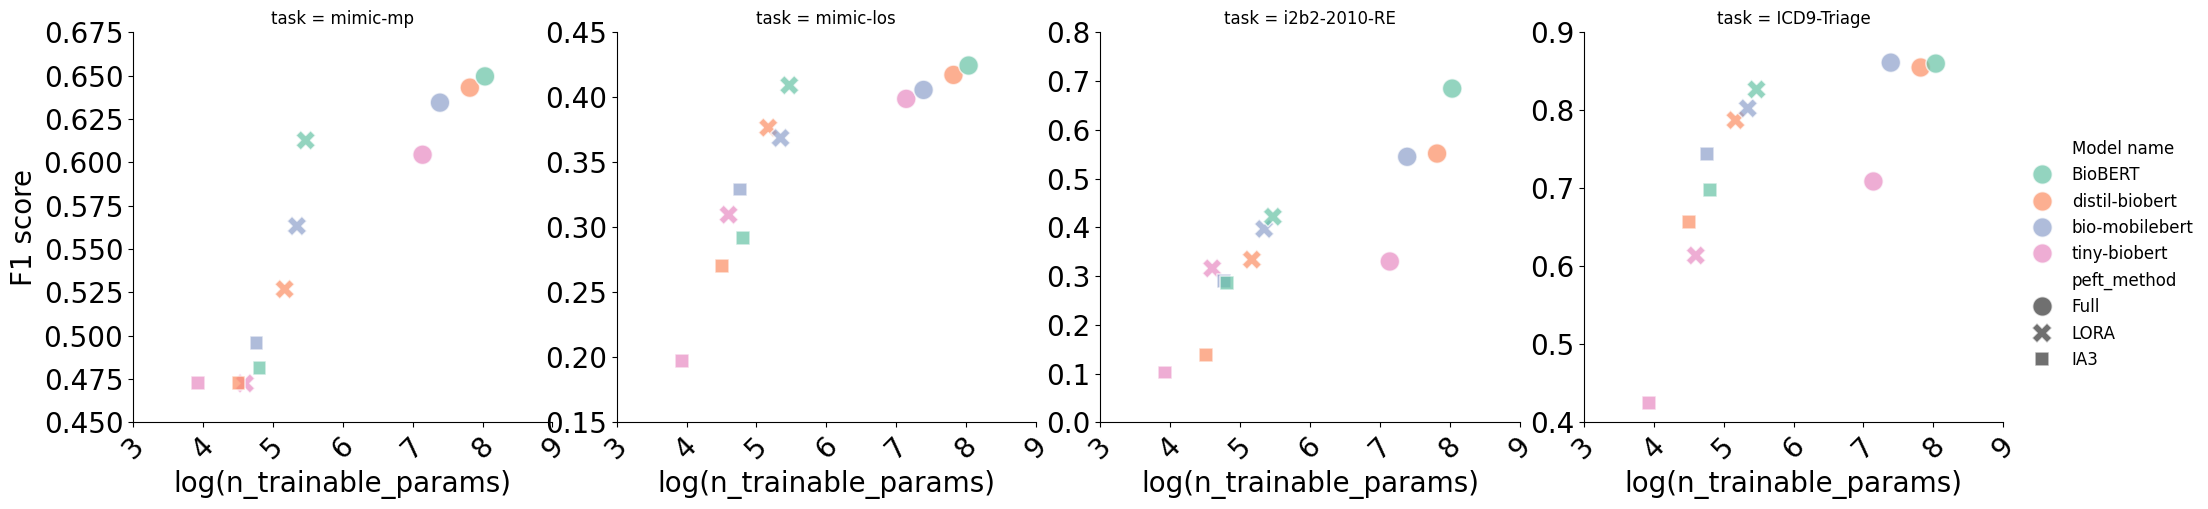

In [113]:
metrics = ['roc_auc_macro', 'f1_macro']
plot_df['log(n_trainable_params)'] = np.log10(plot_df['PEFT_params'])
# have a nicer metric name mapping
metric_name_mapping = {'roc_auc_macro': 'ROC AUC', 'f1_macro': 'F1 score'}

for metric in metrics:
    # change font size
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, 
                       sharex=True, legend_out=True, aspect=1, height=5)
    fg.map_dataframe(sns.scatterplot, x='log(n_trainable_params)', y=metric, style='peft_method', 
                     hue='Model name',
                     hue_order = ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'],
                       palette='Set2', s=200, alpha=0.7,
                     style_order=peft_methods_to_plot[::-1])
    # fg.map_dataframe(sns.lineplot, x='log(n_trainable_params)', y=metric, style='peft_method', 
    #                  hue='Model name', palette='viridis', alpha=0.7,
    #                  style_order=['Full', 'PREFIX_TUNING', 'LORA', 'PROMPT_TUNING'])
    fg.add_legend()
    fg.set_xticklabels(rotation = 45, fontsize =20)
    fg.set_yticklabels(fontsize =20)
    fg.set_xlabels('log(n_trainable_params)', fontsize =20)
    fg.set_ylabels(metric_name_mapping[metric], fontsize =20)
    # set subplot titles
    # fg.set_titles(col_template="{col_name}", row_template="{row_name}", fontsize =30)


    plt.savefig(f'{save_path}/{metric}_peft_methods_trainable_params.png', bbox_inches='tight')
    plt.show()


In [104]:
# plt.rcParams

the style order may be weird

In [44]:
# Plot the lines on two facets
# sns.relplot(
#     data=dots,
#     x="time", y="firing_rate",
#     hue="coherence", size="choice", col="align",
#     kind="line", size_order=["T1", "T2"], palette=palette,
#     height=5, aspect=.75, facet_kws=dict(sharex=False),
# )

In [134]:
plot_df.query("`Model name` == 'Bio-ClinicalBERT' & `task` == 'mimic-los'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,PEFT_params,PEFT_params_perc,Total_params,log(n_trainable_params)
33,33,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,Full,0.443862,0.422290,0.443862,0.438665,0.461359,0.415032,0.705,229376,0.211774,108311810,5.360548
34,34,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,PREFIX_TUNING,0.410840,0.368367,0.410840,0.393162,0.470111,0.362654,0.672,368640,0.340351,108311810,5.566602
35,35,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,PROMPT_TUNING,0.377591,0.268441,0.377591,0.329927,0.442458,0.289024,0.608,7680,0.007091,108311810,3.885361


### Compare multiple models at full sample size

In [91]:
# set models of interest

models_of_interest = ["roberta-base", "Bio_ClinicalBERT", "mimic-roberta-base", "bio-mobilebert", "distil-biobert"]

<Figure size 1200x1000 with 0 Axes>

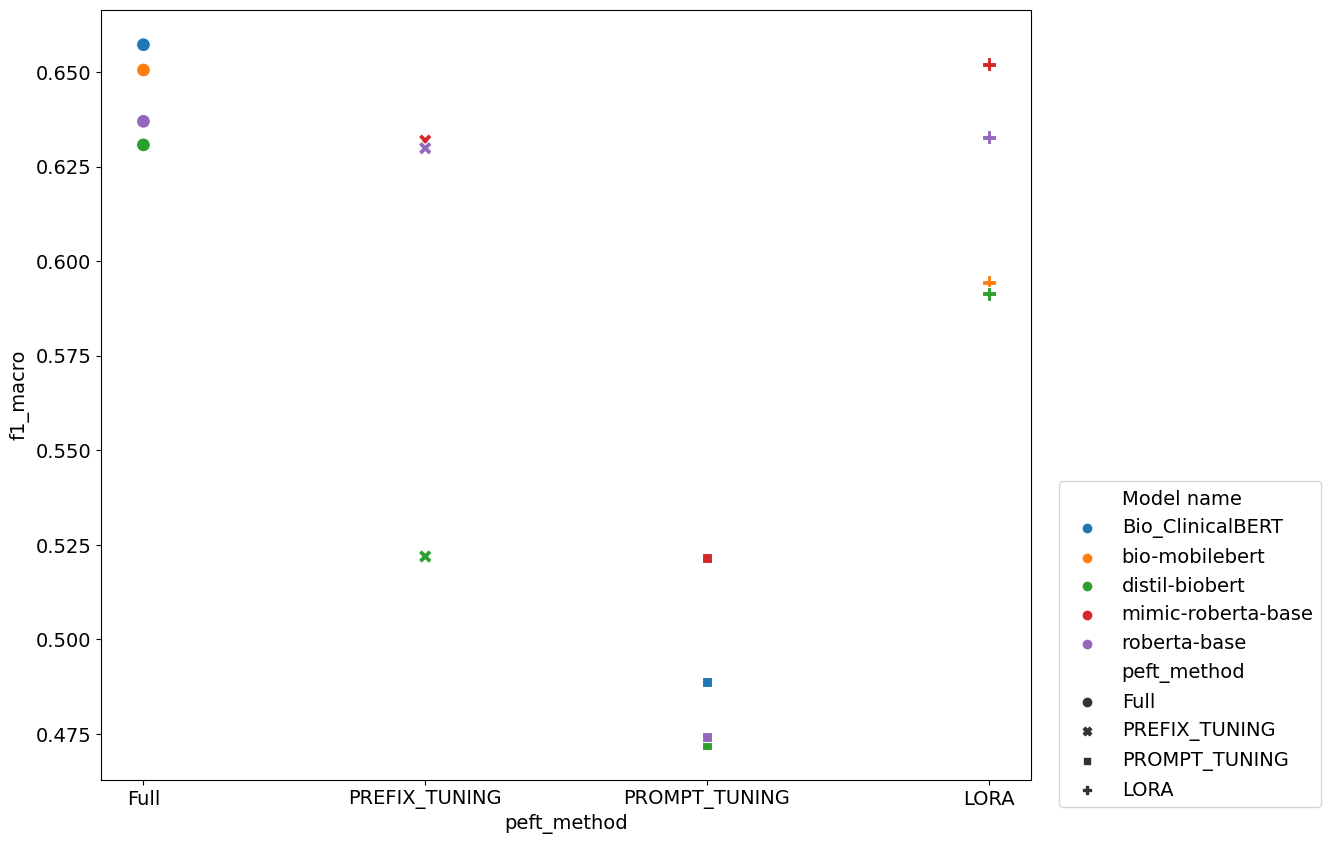

<Figure size 1200x1000 with 0 Axes>

In [18]:
task = "mimic-mp"


# scatter plot for roberta base vs few shot n with hue as peft method
plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(12,10))
g = sns.scatterplot(data = cls_results_df.query("few_shot_n == 250 & task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = "f1_macro",
                    hue = "Model name",
                    style = "peft_method",
                    s = 100, ax = ax)

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = cls_results_df.query("few_shot_n == 250 & task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = "f1_macro",
                    hue = "Model name",
                    style = "peft_method",
                        ax =ax, 
                        legend = False
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))

# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above


# ax.axhline(y=cls_results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")["f1_macro"].values[0], color='black', linestyle='--', alpha = 0.5)

In [31]:
logs_df.task_type.unique()

array(['SEQ_CLS', 'TOKEN_CLS'], dtype=object)

### Look at training time etc

In [33]:
cls_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params
0,0,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,Full,0.948940,0.879353,0.948940,0.949106,...,0.885844,0.993043,1.178996e+16,0.182213,1151.783691,41.497002,1.298,108310272.0,99.998580,108311810.0
1,1,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,IA3,0.904303,0.661928,0.904303,0.889988,...,0.656008,0.982280,1.179958e+16,0.508661,1016.591003,47.014999,1.471,64512.0,0.059561,108311810.0
2,2,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,LORA,0.948298,0.876338,0.948298,0.948010,...,0.874291,0.991595,1.183130e+16,0.281233,973.616028,49.090000,1.536,294912.0,0.272281,108311810.0
3,3,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,PREFIX_TUNING,0.758831,0.377884,0.758831,0.702254,...,0.370109,0.904001,1.179070e+16,0.945242,911.373108,52.443001,1.640,184320.0,0.170175,108311810.0
4,4,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,PROMPT_TUNING,0.724470,0.309875,0.724470,0.646503,...,0.328047,0.892517,1.179070e+16,1.019554,930.424622,51.368999,1.607,7680.0,0.007091,108311810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,328,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,IA3,0.894458,0.472145,0.894458,0.844627,...,0.500000,0.610758,2.286669e+15,0.338250,628.517273,270.112000,8.448,8544.0,0.061579,13874762.0
329,329,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,LORA,0.895273,0.483743,0.895273,0.847377,...,0.505564,0.758608,2.302018e+15,0.310653,592.793823,286.390015,8.958,39936.0,0.287832,13874762.0
330,330,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,PREFIX_TUNING,0.894662,0.484691,0.894662,0.846581,...,0.505162,0.737646,2.282492e+15,0.317243,778.098083,218.186005,6.824,24960.0,0.179895,13874762.0
331,331,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,PROMPT_TUNING,0.894458,0.472145,0.894458,0.844627,...,0.500000,0.608066,2.282492e+15,0.335948,878.742371,193.197006,6.043,3120.0,0.022487,13874762.0


In [34]:
time_grouped_df = cls_results_df.groupby(["Model name", 
                                          "peft_method",
                                          "task",
                                          "few_shot_n"])[["train/train_runtime","train/total_flos", "f1_macro"]].mean().reset_index()

In [32]:
time_grouped_df.query("`Model name` == 'tiny-biobert' & task == 'mimic-los'")

tag,Model name,peft_method,task,few_shot_n,train/train_runtime,train/total_flos,f1_macro
311,tiny-biobert,Full,mimic-los,250.0,672.981689,2.044993e+15,0.394912
316,tiny-biobert,IA3,mimic-los,250.0,567.254883,2.049284e+15,0.200045
326,tiny-biobert,LORA,mimic-los,16.0,50.236301,4.340235e+12,0.082366
327,tiny-biobert,LORA,mimic-los,32.0,51.597698,8.680469e+12,0.117975
328,tiny-biobert,LORA,mimic-los,64.0,52.520100,1.736094e+13,0.185895
329,tiny-biobert,LORA,mimic-los,128.0,57.049000,3.472188e+13,0.229567
330,tiny-biobert,LORA,mimic-los,200.0,61.754700,5.425293e+13,0.239175
331,tiny-biobert,LORA,mimic-los,250.0,529.658508,2.063036e+15,0.332569
341,tiny-biobert,PREFIX_TUNING,mimic-los,250.0,696.214905,2.045541e+15,0.303347
346,tiny-biobert,PROMPT_TUNING,mimic-los,250.0,784.993591,2.045541e+15,0.200091


In [37]:
time_grouped_df.query("peft_method == 'LORA' and few_shot_n == 250")

tag,Model name,peft_method,task,few_shot_n,train/train_runtime,train/total_flos,f1_macro
10,Bio-ClinicalBERT,LORA,ICD9-Triage,250.0,973.616028,1.183130e+16,0.876338
16,Bio-ClinicalBERT,LORA,i2b2-2010-RE,250.0,1168.505249,1.361401e+16,0.406977
17,Bio-ClinicalBERT,LORA,mednli,250.0,217.321594,3.172938e+15,0.266870
21,Bio-ClinicalBERT,LORA,mimic-los,250.0,2841.795898,3.765043e+16,0.400606
23,Bio-ClinicalBERT,LORA,mimic-mp,250.0,3164.370850,4.202153e+16,0.636708
44,BioLinkBERT-base,LORA,i2b2-2010-RE,250.0,1608.011230,1.207389e+16,0.468533
45,BioLinkBERT-base,LORA,mednli,250.0,281.238190,2.614242e+15,0.269277
46,BioLinkBERT-base,LORA,mimic-los,250.0,2780.993896,3.765043e+16,0.411788
47,BioLinkBERT-base,LORA,mimic-mp,250.0,3105.887695,4.202153e+16,0.651606
68,LinkBERT-base,LORA,i2b2-2010-RE,250.0,1858.796143,1.368241e+16,0.369720


In [35]:
# peft_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full']
peft_methods_to_plot = ['IA3', 'LORA', 'Full']
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] > 200].copy()
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['distil-biobert', 'bio-mobilebert', 'tiny-biobert', 'BioBERT'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]

plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [40]:
cls_results_df["Model name"].unique()

array(['Bio-ClinicalBERT', 'BioBERT', 'BioLinkBERT-base', 'LinkBERT-base',
       'Mimic-RoBERTa-DeCLUTR', 'RoBERTa-base', 'RoBERTa-mimic',
       'RoBERTa-mimic-note-two-epoch', 'bio-mobilebert', 'distil-biobert',
       'roberta-base-mimic-note-custom_pretraining_contrastive_max_epoch_2_weighted',
       'tiny-biobert'], dtype=object)

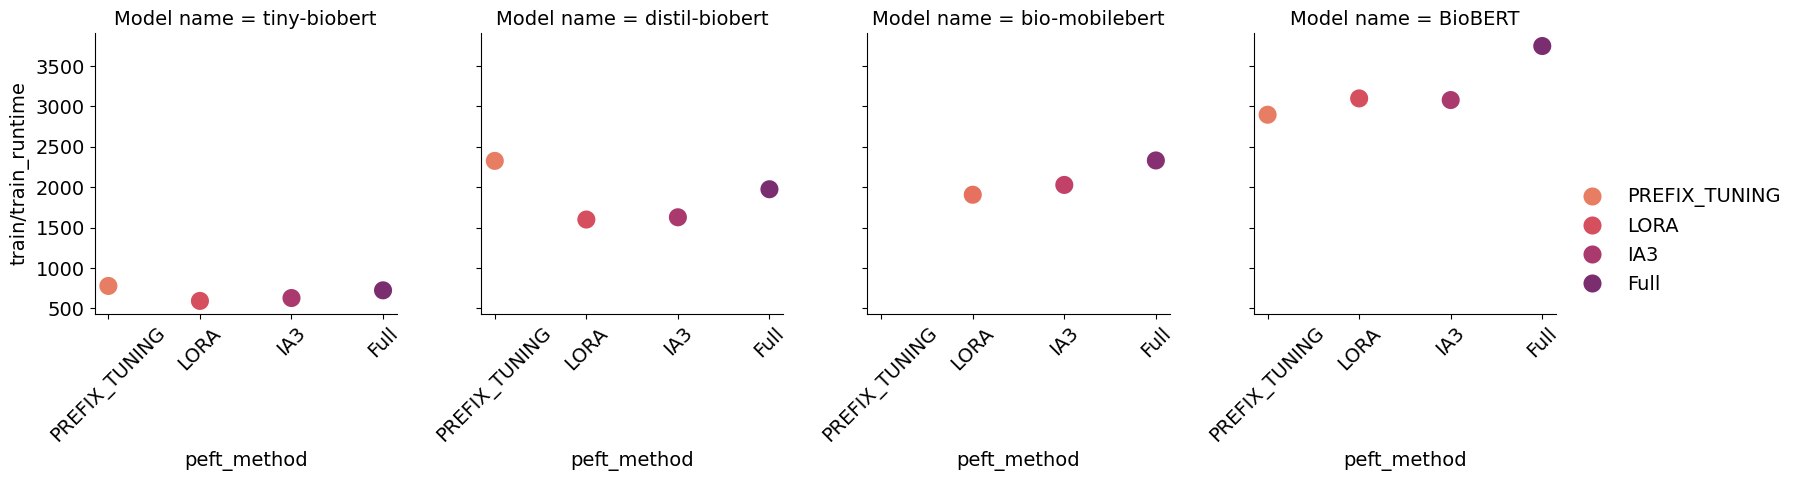

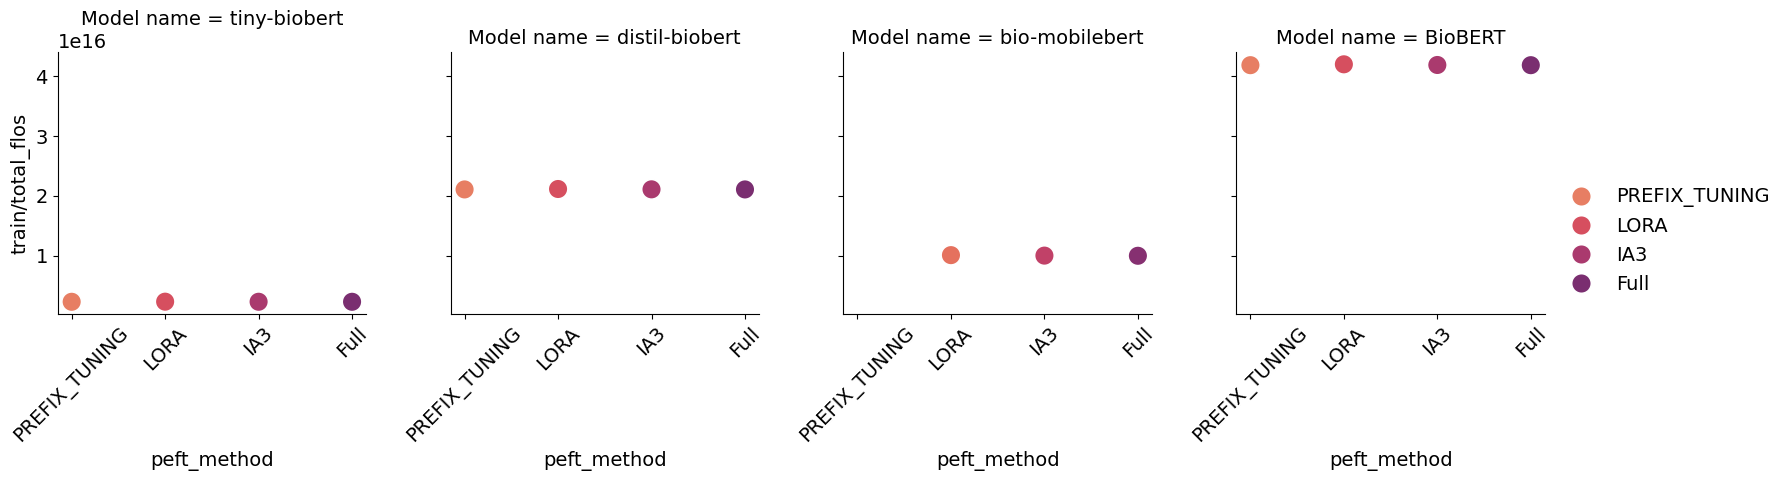

In [71]:
task = "mimic-mp"

metrics = ["train/train_runtime","train/total_flos"]

for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df.query("task == @task"), col='Model name', sharey=True, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.scatterplot, x='peft_method', y=metric, hue='peft_method', 
                    # order=peft_methods_to_plot, 
                    palette='flare',
                    s = 200)
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.show()

In [40]:
# how many nas in train_runtime
plot_df["train/total_flos"].isna().sum()

0

In [39]:
plot_df["train/train_runtime"]

351     778.098083
340     696.214905
329      68.249603
323     265.755798
312     262.315308
          ...     
57     3748.081299
55      388.900787
49      280.701111
44     1384.306396
39     1138.175049
Name: train/train_runtime, Length: 75, dtype: float64

In [76]:
plot_df.query("`Model name` == 'bio-mobilebert' & `task` == 'mimic-mp'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,log(train/train_runtime)
259,259,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,LORA,0.897922,0.594404,NaN,0.870632,...,0.805,1.008930e+16,80.762421,1907.081055,89.021004,2.784,221184.0,0.899747,24582914.0,3.280369
258,258,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,IA3,0.894662,0.506085,0.894662,0.851521,...,0.760,1.000969e+16,55.185074,2028.612427,83.688004,2.618,58368.0,0.237433,24582914.0,3.307199
257,257,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,Full,0.901793,0.650529,0.901793,0.880001,...,0.824,9.980649e+15,59.196644,2331.474121,73.668999,2.304,24581888.0,99.995826,24582914.0,3.367631


ValueError: s must be a scalar, or float array-like with the same size as x and y

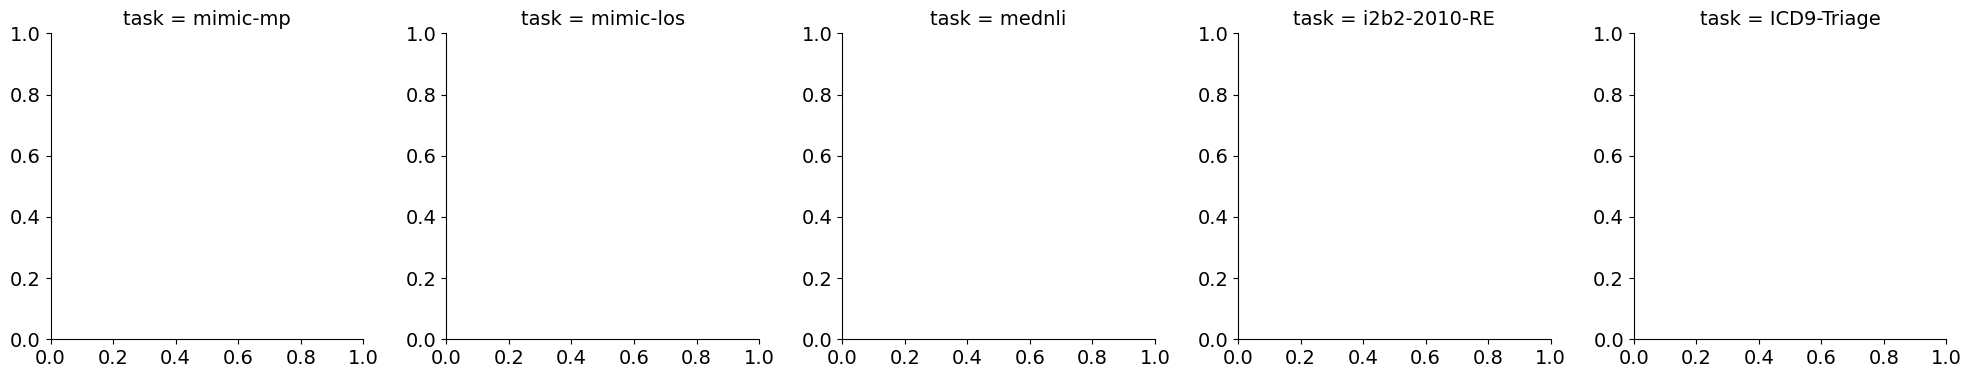

In [51]:
task = "mimic-mp"
peft_methods_to_plot = ["IA3", "LORA","Full"]
metrics = ["f1_macro", "roc_auc_macro"]
time_metric = "train/train_runtime"
plot_df['log(n_trainable_params)'] = np.log2(plot_df['PEFT_params'])
for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, sharex=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.scatterplot, x=time_metric, y=metric ,
                    hue='Model name',
                    palette='viridis',
                    style = "peft_method",
                    # size = 'log(n_trainable_params)',
                    # size = 200,
                    s = plot_df["log(n_trainable_params)"],
                    )
    
    # remove x ticks
    fg.set(xticks=[])
    
    # fg.map_dataframe(sns.lineplot,
    #                  x = metric, 
    #                  y = cls_metric,
                      
    #                 palette='flare')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.show()

In [52]:
task

'mimic-mp'

Text(0.5, 1.0, 'Scatterplot with Seaborn')

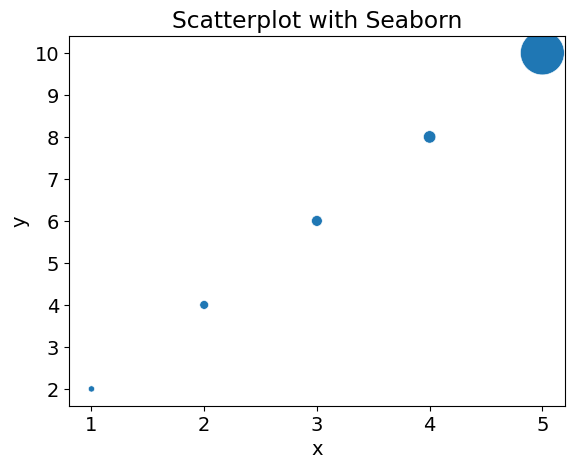

In [88]:

df = pd.DataFrame({'x': [1, 2, 3, 4, 5], 
                   'y': [2, 4, 6, 8, 10],
                   'size': [20.0, 40, 60, 80, 1000]})

ax = sns.scatterplot(data=df, x='x', y='y', s=df['size'])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Scatterplot with Seaborn')

In [64]:
df

,x,y,size
0,1,2,20
1,2,4,40
2,3,6,60
3,4,8,80
4,5,10,100


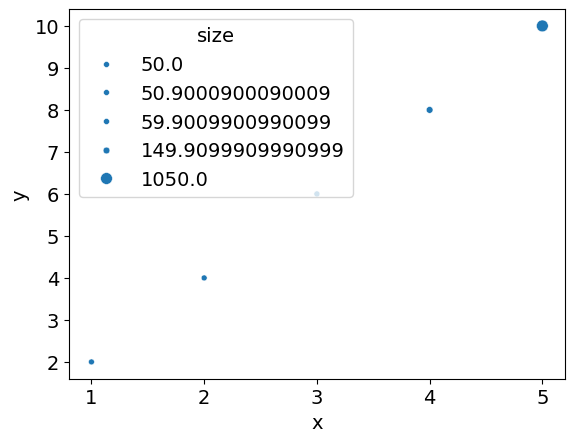

In [104]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({'x': [1, 2, 3, 4, 5],  
                   'y': [2, 4, 6, 8, 10],
                   'size': [1000, 10000, 100000, 1000000, 10000000]})

# Normalize sizes to range from 50 to 500
sizes = 50 + (df['size'] - df['size'].min()) / (df['size'].max() - df['size'].min()) * 1000

ax = sns.scatterplot(data=df, x='x', y='y', size=sizes)

# ax.set_yscale('log')

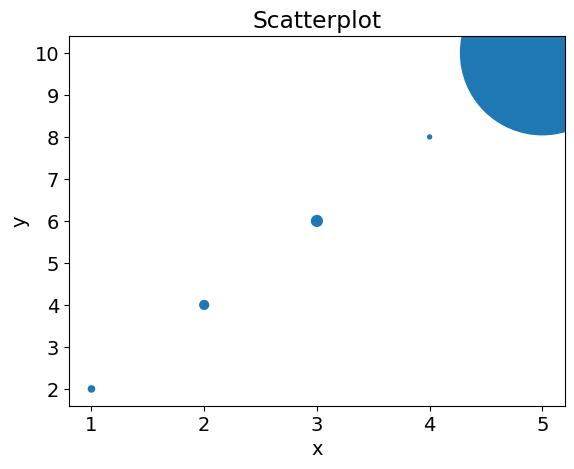

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'x': [1, 2, 3, 4, 5], 
                   'y': [2, 4, 6, 8, 10],
                   'size': [20, 40, 60, 8, 13874.0]})

plt.scatter(df['x'], df['y'], s=df['size'])

plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatterplot')

plt.show()

In [97]:
# mean std scaling of peft params
# plot_df['norm_PEFT_params'] = ((plot_df['PEFT_params'] - plot_df['PEFT_params'].mean()) / plot_df['PEFT_params'].std())*10
plot_df['norm_PEFT_params'] = (plot_df['PEFT_params'])/1000

(array([41.,  5.,  5.,  0.,  0.,  0.,  5.,  0.,  0.,  5.]),
 array([8.54400000e+00, 1.08387168e+04, 2.16688896e+04, 3.24990624e+04,
        4.33292352e+04, 5.41594080e+04, 6.49895808e+04, 7.58197536e+04,
        8.66499264e+04, 9.74800992e+04, 1.08310272e+05]),
 <BarContainer object of 10 artists>)

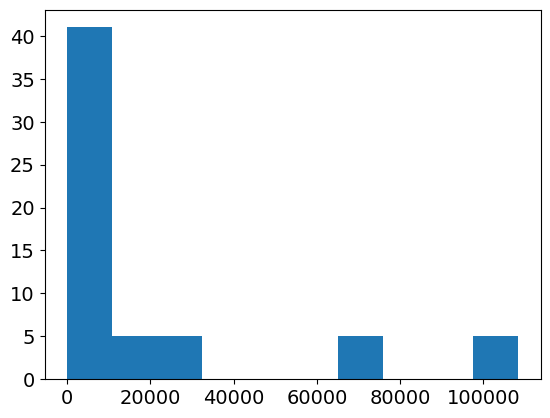

In [98]:
plt.hist(plot_df['norm_PEFT_params'])

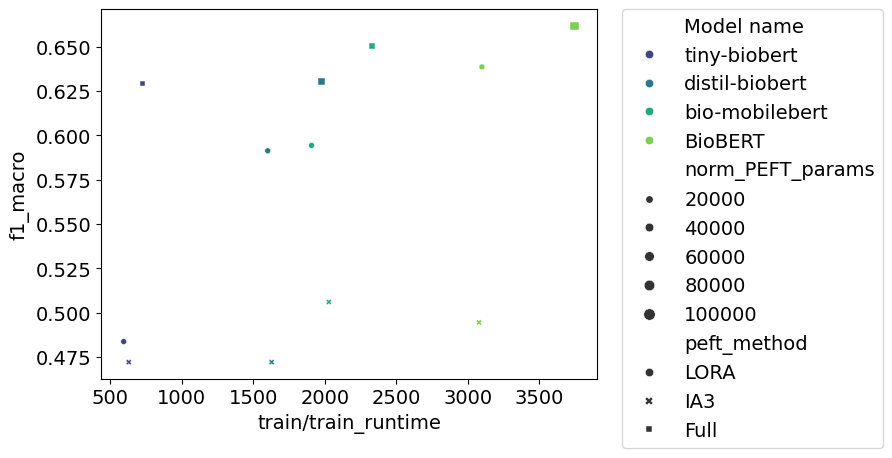

In [99]:
# single task plot
pdf = plot_df.query("task == @task").reset_index(drop=True)
sns.scatterplot(x="train/train_runtime", y=metric ,
                    hue='Model name',
                    palette='viridis',
                    style = "peft_method",
                    size = pdf["norm_PEFT_params"],
                    data = pdf)

# move legend outside 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                    

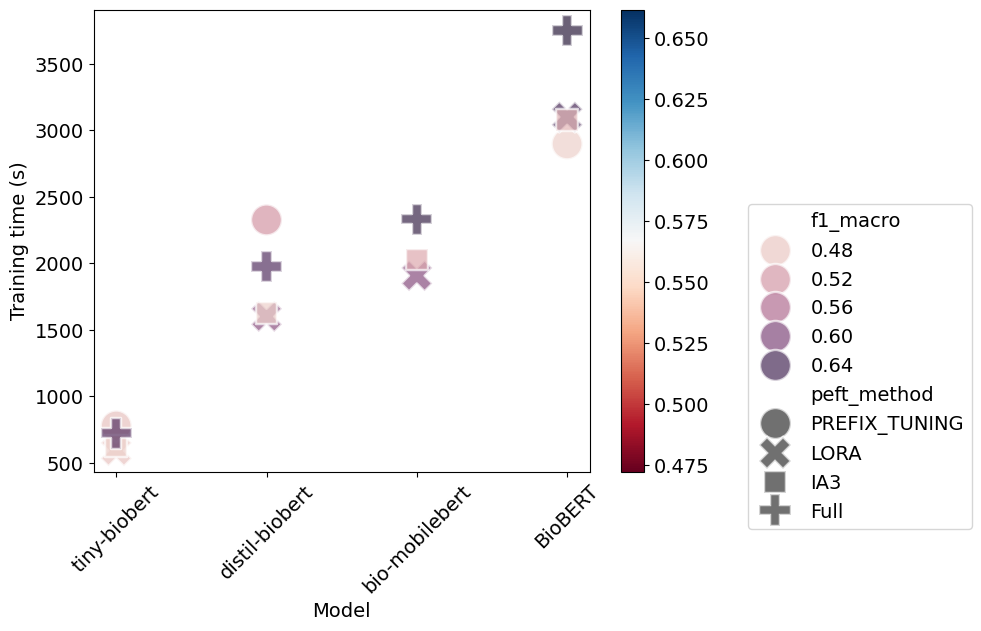

In [47]:
# make plot
plt.figure(figsize=(8, 6))
cls_metric = "f1_macro"
peft_type = "LORA"
time_plot_df = plot_df.query("task == @task and peft_method == @peft_type")
time_plot_df = plot_df.query("task == @task")
ax = sns.scatterplot(data = time_plot_df,
                     x = "Model name",
                     y = "train/train_runtime",
                     hue = cls_metric,
                     style="peft_method",
                     s = 500,
                     alpha = 0.7,
                     
                     )
norm = plt.Normalize(time_plot_df[cls_metric].min(), time_plot_df[cls_metric].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
# ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)
# plt.suptitle(f"Alignment vs Uniformity for label {label}")
plt.xlabel("Model")
# rotate x tick labels by 45
plt.xticks(rotation=45)
plt.ylabel("Training time (s)")

    # for line in range(0,uniform_align_dfs.shape[0]):
    #     # print(f"line {line}")
    #     plt.text(uniform_align_dfs.iloc[line].uniform_loss+0.002, uniform_align_dfs.iloc[line].align_loss+0.02, uniform_align_dfs.iloc[line].model_name, horizontalalignment='center', size='medium', color='black', weight='semibold')
# texts = []
# for line in range(0,time_plot_df.shape[0]):
#     texts.append(plt.text(time_plot_df.iloc[line]["train/train_runtime"]+0.002,
#                           time_plot_df.iloc[line]["train/train_runtime"]+0.02,
#                           time_plot_df.iloc[line]["Model name"],
#                           horizontalalignment='left',
#                           size='medium',
#                           color='black',
#                           weight='semibold'))


# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'))
# adjust_text(texts)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.3, 0.6))
plt.savefig(f'{save_path}/{cls_metric}_peft_methods_train_time.png', bbox_inches='tight')
plt.show()

## Sensitivity analysis


### Time budget

In [7]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/tb_2000/logs/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))

fs_logs_df.shape

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/56226 [00:00<?, ?it/s]

(56226, 63)

In [8]:
llama_logs = fs_logs_df.loc[fs_logs_df['Model name'] == 'Llama-2-7b']
fs_logs_df = fs_logs_df.loc[fs_logs_df['scheduler_type'] == 'linear']
fs_logs_df = pd.concat((fs_logs_df, llama_logs))

# Group by model name and peft method and keep all rows with only the
# latest datetime
fs_logs_df = fs_logs_df.loc[fs_logs_df.groupby(
    ['Model name', 'peft_method'])['datetime'].transform(
        lambda x: x == x.max()).reindex()]

fs_logs_df.shape

(24882, 63)

In [9]:
fs_logs_df.groupby(['Model name', 'peft_method'])['datetime'].value_counts()

Model name      peft_method  datetime           
BioBERT         Full         2024-01-05 15:45:00    2304
                LORA         2024-01-05 12:55:00    2304
Llama-2-7b      LORA         2024-01-04 09:30:00     621
RoBERTa-base    Full         2024-01-05 14:14:00    2304
                LORA         2024-01-05 11:35:00    2304
bio-mobilebert  Full         2024-01-05 17:22:00    1389
                LORA         2024-01-04 17:11:00    1581
distil-biobert  Full         2024-01-04 22:08:00    1587
                LORA         2024-01-04 21:33:00    1878
tiny-biobert    Full         2024-01-04 19:36:00    4011
                LORA         2024-01-04 19:01:00    4599
Name: count, dtype: int64

/tmp/ipykernel_47068/2031667419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Time (s)'] = plot_df.groupby(['Model name', 'peft_method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values


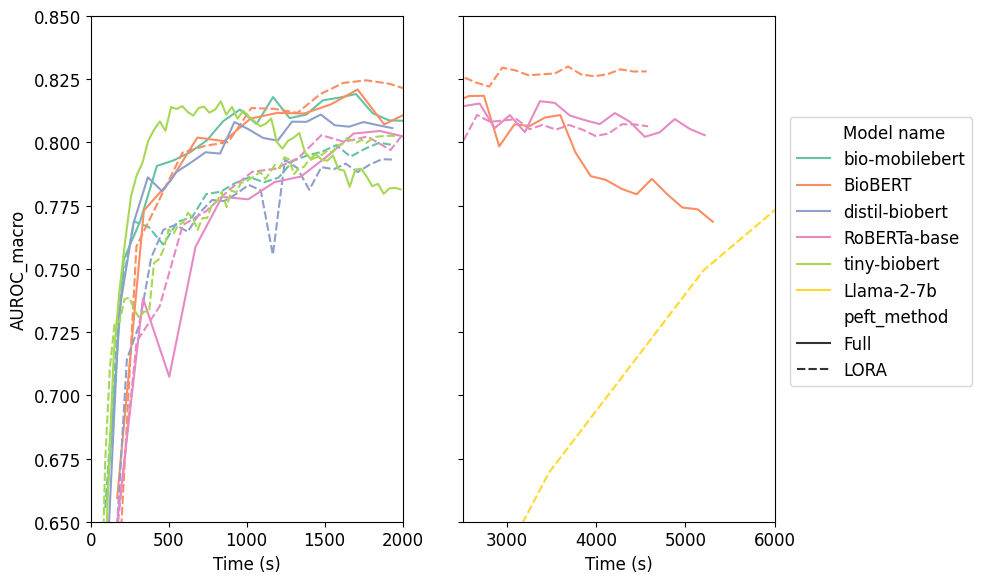

In [58]:
plot_df = fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'peft_method']]
plot_df['Time (s)'] = plot_df.groupby(['Model name', 'peft_method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values
plot_df = plot_df.loc[plot_df['tag'].str.contains('eval/roc_auc')]
plot_df.rename(columns={'value': 'AUROC_macro'}, inplace=True)
# fg = sns.FacetGrid(data=plot_df, col='peft_method', sharey=True, sharex=True, 
#                    legend_out=True, aspect = 1, height = 4, 
#                    col_order=['Full', 'LORA'])
# fg.map_dataframe(sns.lineplot, x='rel_time', y='value', hue='Model name', 
#                  hue_order=plot_df['Model name'].unique(), palette='Set2')
# fg.add_legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=False)
ax = ax.flatten()
for ax_num, xrange in enumerate([(0, 2000), (2500, 6000)]):
    sns.lineplot(data=plot_df, x='Time (s)', y='AUROC_macro', 
                hue='Model name', hue_order=plot_df['Model name'].unique(), 
                style='peft_method', style_order=['Full', 'LORA'], 
                palette='Set2', ax=ax[ax_num], legend=ax_num==len(ax)-1)
    ax[ax_num].set_xlim(xrange)
    ax[ax_num].set_ylim((0.65, 0.85))

# move seaborn legend outside
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(f'{save_path}/time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.savefig(f'time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()



### Fewshot budget

In [62]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/fewshot_budget/logs/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))

fs_logs_df.shape

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/25617 [00:00<?, ?it/s]

(25617, 63)

In [63]:
fs_cls_results_df = produce_results_table(fs_logs_df,
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

/tmp/ipykernel_47068/3622975400.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(str)
/tmp/ipykernel_47068/3622975400.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.rename(columns={'few_shot_n': 'Num training samples',


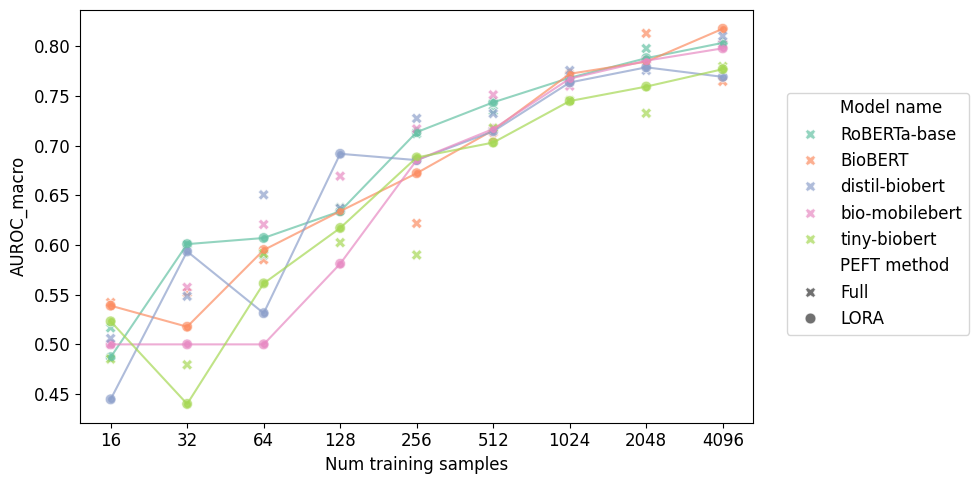

In [109]:
# same as above but with facet
plot_df = fs_cls_results_df.loc[fs_cls_results_df['Model name'] != 'Llama-2-7b']
# convert few_shot_n to string
plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(str)
plot_df.rename(columns={'few_shot_n': 'Num training samples', 
                        'roc_auc_macro':'AUROC_macro',
                        'peft_method': 'PEFT method'}, inplace=True)
metrics = ['AUROC_macro']

for metric in metrics:

    # plt.figure(figsize=(7, 7))
    # fg = sns.FacetGrid(data=plot_df,
    #                   col='peft_method', 
    #                   sharey=True,
    #                   sharex=True,
    #                   legend_out=True,
    #                   aspect = 1, 
    #                   height = 4,
    #                   )
    # fg.map_dataframe(sns.pointplot,
    #                   x='few_shot_n',
    #                   y=metric,
    #                   hue='Model name', 
    #                 #   hue_order = ["RoBERTa-base", "BioBERT", "distil-biobert", "bio-mobilebert", "tiny-biobert"],
    #                   alpha=0.7,
    #                   linewidth=1.5,
    #                   markersize=4,
    #                   palette='Set2')
    # fg.add_legend()
    hue_order = ["RoBERTa-base", "BioBERT", "distil-biobert", "bio-mobilebert", "tiny-biobert"]
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.pointplot(data=plot_df.loc[plot_df['PEFT method'] == 'LORA'], 
                  x='Num training samples', y=metric, 
                  hue='Model name', hue_order = hue_order,
                  alpha=0.7, linewidth=1.5, markersize=4, palette='Set2', legend=False)
    sns.scatterplot(data=plot_df, 
                  x='Num training samples', y=metric, 
                  hue='Model name', hue_order = hue_order,
                  style='PEFT method', style_order=['Full', 'LORA'],
                  alpha=0.7, markers=['X', 'o'], s=60, palette='Set2')
    
    plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'{save_path}/fewshot_sensitivity.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'fewshot_sensitivity.png', bbox_inches='tight', dpi=300)
    plt.show()